# Teacher's Assignment - Extra Credit #1

***Author:*** *Ofir Paz* $\qquad$ ***Version:*** *15.07.2024* $\qquad$ ***Course:*** *22961 - Deep Learning* \
***Extra Assignment Course:*** *20998 - Extra Assignment 3*

Welcome to the first question of the extra assignment #1 as part of the course *Deep Learning*. \
In this question we will train an RNN network for classification on the SST-2 dataset while dealing with the exploding gradient problem.

## Imports

In [1]:
import torch  # pytorch.
import torch.nn as nn  # neural network module.
import torch.optim as optim  # optimization module.
import torch.nn.functional as F  # functional module.
import numpy as np  # numpy.
from torch.utils.data import DataLoader, Dataset  # data handling.
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torchtext.vocab import build_vocab_from_iterator  # vocabulary builder.
import matplotlib.pyplot as plt  # plotting module.
import datasets as ds  # public dataset module.
from base_model import BaseModel  # base model class.

# Type hinting.
from torch import Tensor
from torchtext.vocab import Vocab
from typing import Tuple

## Loading & Pre-Processing

In [2]:
# Load the SST-2 dataset.
dataset: ds.DatasetDict = ds.load_dataset("glue", "sst2")  # type: ignore

train_set = dataset["train"][:1500]
validation_set = dataset["validation"][:500]
test_set = dataset["test"]

In [3]:
# Create the vocabulary.
vocab = build_vocab_from_iterator(map(str.split, train_set["sentence"]), specials=["<unk>"], min_freq=5)
vocab.set_default_index(vocab["<unk>"])

In [4]:
# Create the SST-2 dataset.
class SST2Dataset(Dataset):
    def __init__(self, dataset: ds.Dataset, vocab: Vocab) -> None:
        self.sentences = list(map(lambda seq: torch.tensor(vocab(seq.split())), dataset["sentence"]))
        self.labels = torch.tensor(dataset["label"], dtype=torch.long)

    def __len__(self) -> int:
        return len(self.sentences)

    def __getitem__(self, idx) -> Tuple[Tensor, Tensor]:
        return self.sentences[idx], self.labels[idx]

In [5]:
train_dataset = SST2Dataset(train_set, vocab)
validation_dataset = SST2Dataset(validation_set, vocab)
test_dataset = SST2Dataset(test_set, vocab)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

## The RNN

In [7]:
class RNNClasifer(BaseModel):
    """
    Recurrent Neural Network (RNN) classifier, designed specifically for the SST-2 dataset.
    """
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, num_classes: int,
                 **kwargs) -> None:
        super(RNNClasifer, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn_cell = nn.RNNCell(embed_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.saved_grads = []
        
        # Define t, the maximum time steps that the gradient will be 
        # backpropagated through in the RNN.
        self.t = 10_000

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: Tensor of shape (batch_size, seq_len)
        t: token index at which to stop gradient propagation.
                Gradients will only be propagated from tokens at or after this index.
        """
        self.saved_grads = []  # Reset the saved gradients.
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        h_t = torch.zeros(batch_size, self.rnn_cell.hidden_size, device=x.device)

        # Unroll the recurrence manually
        for i in range(seq_len):
            # Process the i-th token.
            h_t = self.rnn_cell(embedded[:, i, :], h_t)

            if self.training:
                # (Optional) Register a hook to observe gradient flow.
                h_t.register_hook(lambda grad: self.saved_grads.append(grad.norm().item()))
                # Detach the hidden state once we hit the t token.
                if i == self.t:
                    h_t = h_t.detach()
            if i >= self.t:
                self.saved_grads.append(0.0)  # Pad the gradient list.
        logits = self.fc(h_t)
        return logits
    
    def plot_grads(self) -> None:
        """
        Plot the gradient norms for each token in the sequence.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.saved_grads, marker='o', linestyle='-', color='b', label='Gradient Norm')
        plt.xlabel("Token Index", fontsize=12)
        plt.ylabel("Gradient Norm", fontsize=12)
        plt.title("Gradient Norms for Each Token in the Sequence", fontsize=14)
        plt.grid(True)
        plt.legend()
        plt.show()

In [8]:
# Define t, the maximum time steps that the gradient will be 
# backpropagated through in the RNN.
t = 5

torch.Size([1, 10])


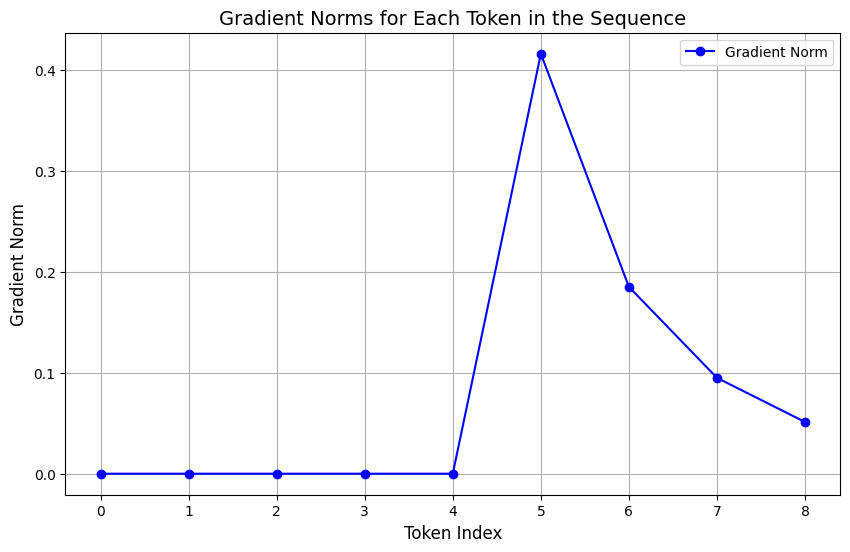

In [9]:
# Initialize the model.
model = RNNClasifer(len(vocab), embed_dim=32, hidden_dim=64, num_classes=2, task_type="classification")
model.t = t

# Dummy input: batch_size = 1, seq_len = 10
x = torch.randint(0, len(vocab), (1, 10))
print(x.shape)

logits = model(x)
loss = F.cross_entropy(logits, torch.tensor([0]))
loss.backward()
model.plot_grads()

In [10]:
# Train the model. with t=1000, the gradient will be backpropagated through all tokens.
model1 = RNNClasifer(len(vocab), embed_dim=32, hidden_dim=64, num_classes=2, task_type="classification")
model1.t = 1000
model1.fit(train_loader, validation_loader, num_epochs=3, try_cuda=False)

Using CPU for training.
[epoch: 01/03] [Train loss: 0.701377  Train Accuracy: 0.518]  [Val loss: 0.807610]  Val Accuracy: 0.532]
[epoch: 02/03] [Train loss: 0.689187  Train Accuracy: 0.555]  [Val loss: 0.691910]  Val Accuracy: 0.544]
[epoch: 03/03] [Train loss: 0.683476  Train Accuracy: 0.555]  [Val loss: 0.721586]  Val Accuracy: 0.504]


In [11]:
# Train the model. with t=10
model2 = RNNClasifer(len(vocab), embed_dim=32, hidden_dim=64, num_classes=2, task_type="classification")
model2.t = 10
model2.fit(train_loader, validation_loader, num_epochs=3, try_cuda=False)

Using CPU for training.
[epoch: 01/03] [Train loss: 0.701830  Train Accuracy: 0.525]  [Val loss: 0.691991]  Val Accuracy: 0.518]
[epoch: 02/03] [Train loss: 0.671791  Train Accuracy: 0.585]  [Val loss: 0.693550]  Val Accuracy: 0.534]
[epoch: 03/03] [Train loss: 0.658446  Train Accuracy: 0.592]  [Val loss: 0.698110]  Val Accuracy: 0.532]
